# New Gaussian Process API (v 0.18) 

In [95]:
import random
import sys

import matplotlib.pyplot as plt
import sklearn
import sklearn.gaussian_process as gp
import numpy as np

print("Using Python: {0}\nscikit-learn version: {1}".format(
    sys.executable, sklearn.__version__
))

%matplotlib inline

RANDOM_SEED = 0xDEADBEEF
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Using Python: /Users/andrei/anaconda3/envs/crowd/bin/python
scikit-learn version: 0.18.1


## Generating some fake data

LML: -111.703419005
{'alpha': 0.1, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.0, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1), 'n_restarts_optimizer': 5, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}


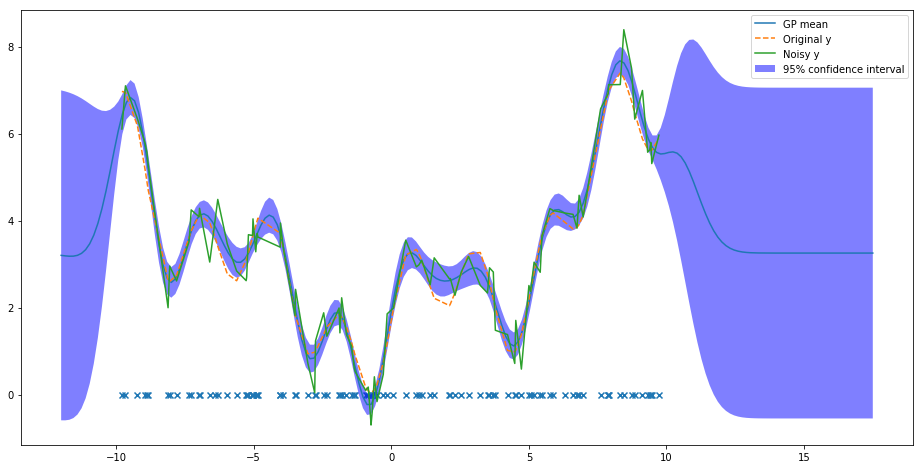

In [88]:
# Make an interesting fake function
N = 100
x_min = -10
x_max = +10
# Avoid using linspace so that our data points are NOT equidistant
X = np.sort(np.random.uniform(size=(N))) * (x_max - x_min) + x_min
X = X.reshape(-1, 1)
eta = np.random.normal(loc=0.0, scale=0.5, size=(N))

y_clean = np.sin(X * 2.5) + np.sin(X * 1.0) + X * 0.05 + np.multiply(X, X) * 0.05 + 1.7
y_clean = y_clean.ravel()
y = y_clean + eta

# GP Regression using the sleek new API from scikit-learn 0.18+
kernel = gp.kernels.ConstantKernel() * gp.kernels.RBF()
# Indicates the noise level in the targets. This is what is added
# to the diagonal of the kernel matrix during fitting.
# Default value: 1e-10
# Note: can incorporate a WhiteKernel component into the kernel, which will
# then estimate the noise from the data.
alpha = 0.1
gpr = gp.GaussianProcessRegressor(
    kernel,
    alpha=alpha,
    n_restarts_optimizer=5,
    normalize_y=True)
gpr.fit(X, y)
print("LML:", gpr.log_marginal_likelihood())
print(gpr.get_params())

# TODO(andrei): Try predicting WITHOUT fitting!
lin_Xs = np.linspace(x_min - 2.0, x_max + 7.5, N * 2).reshape(-1, 1)
y_pred, y_pred_std = gpr.predict(lin_Xs, return_std=True)

# Plot everything
plt.figure(figsize=(16, 8))
plt.plot(lin_Xs, y_pred, label="GP mean")
plt.plot(X, y_clean.T, '--', label="Original y")
plt.plot(X, y.T, label="Noisy y")

plt.scatter(X, np.zeros_like(X), marker='x')


plt.fill_between(lin_Xs.ravel(),
                 y_pred.T - y_pred_std.T * 1.9600,
                 y_pred.T + y_pred_std.T * 1.9600,
                label="95% confidence interval",
                interpolate=True,
                facecolor='blue',
                alpha=0.5)
plt.legend()

## Using sample scikit-learn classification dataset

In [89]:
iris_dataset = sklearn.datasets.load_iris()

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import *

def gp_clf_iris():
    # Follow the example from the sklearn docs, and only use the
    # first two features, so we can visualize the predicted
    # probabilities in 2D.
    X = iris_dataset.data[:, :2]
    y = iris_dataset.target
    y_names = iris_dataset.target_names
    print("Feature names: ", iris_dataset.feature_names)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=RANDOM_SEED)

    # Make the RBF kernel anisotropic for maximum flexibility.
    kernel = gp.kernels.RBF(np.ones((X.shape[1], 1))) \
        * gp.kernels.ConstantKernel() \
        + gp.kernels.WhiteKernel()
    clf = gp.GaussianProcessClassifier(kernel, n_restarts_optimizer=0)
    print("Fitting Gaussian Process on input of shape {0}...".format(
        X_train.shape
    ))
    clf.fit(X_train, y_train)
    print("Learned kernel: {0}".format(str(clf.kernel_)))
    print("Fit complete.")
    
    y_pred = clf.predict(X_test)
    print(y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {0:.2f}%".format(acc * 100.0))
    
    # Plot class probabilities in 2D, with the coordinates being the
    # values of the first and second features (f0, f1, i.e., sepal
    # length and sepal width).
    f0_min = X[:, 0].min() - 1
    f0_max = X[:, 0].max() + 1
    f1_min = X[:, 1].min() - 1
    f1_max = X[:, 1].max() + 1
    step = 0.02
    f0, f1 = np.meshgrid(np.arange(f0_min, f0_max, step),
                         np.arange(f1_min, f1_max, step))
    grid_data = np.c_[f0.ravel(), f1.ravel()]
    print(X.shape)
    print(X_train.shape)
    print(grid_data.shape)
    prob_grid = clf.predict_proba(grid_data)
    prob_grid = prob_grid.reshape((f0.shape[0], f0.shape[1], 3))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(prob_grid, extent=(f0_min, f0_max, f1_min, f1_max),
               origin='lower')

    plt.scatter(X[y==0, 0], X[y==0, 1], s=30, c='red', edgecolors='black')
    plt.scatter(X[y==1, 0], X[y==1, 1], s=30, c='green', edgecolors='black')
    plt.scatter(X[y==2, 0], X[y==2, 1], s=30, c='blue', edgecolors='black')
    
gp_clf_iris()

Feature names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Fitting Gaussian Process on input of shape (127, 2)...
